In [1]:
import os
import re
import glob
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt


# ----------------------------
# 1) parsing helpers
# ----------------------------
FNAME_RE = re.compile(
    r"^(?P<prompt>\d+)-(?P<gen>\d+)-(?P<block>\d+)-(?P<unmask>\d+)\.(?P<model>.+)$"
)

# Matches: "[optional timestamp] ppl | conf" OR "ppl | conf" OR just "ppl"
LINE_RE = re.compile(
    r"""^\s*
        (?:\[[^\]]*\]\s*)?          # optional [timestamp]
        (?P<ppl>[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)   # perplexity float
        (?:\s*\|\s*
            (?P<conf>[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)  # confidence float (optional)
        )?
        \s*$
    """,
    re.VERBOSE,
)


def parse_filename(path):
    base = os.path.basename(path)
    m = FNAME_RE.match(base)
    if not m:
        return None
    d = m.groupdict()
    return {
        "prompt_length": int(d["prompt"]),
        "generation_length": int(d["gen"]),
        "block_size": int(d["block"]),
        "unmask_number": int(d["unmask"]),
        "model": d["model"],
    }


def parse_file_lines(path):
    ppls = []
    confs = []
    with open(path, "r", encoding="utf-8") as f:
        for line_no, line in enumerate(f, 1):
            line = line.strip()
            if not line:
                continue
            m = LINE_RE.match(line)
            if not m:
                # ignore unrecognized lines
                continue
            ppl = float(m.group("ppl"))
            ppls.append(ppl)
            conf = m.group("conf")
            if conf is not None:
                confs.append(float(conf))
    return ppls, confs


# ----------------------------
# 2) load + aggregate
# ----------------------------
def load_results(
    folder,
    prompt_length,
    generation_length,
    unmask_number,
):
    """
    Returns:
      data[model][block_size] = dict(mean_ppl=..., std_ppl=..., n=...)
    """
    data = defaultdict(dict)

    for path in glob.glob(os.path.join(folder, "*")):
        info = parse_filename(path)
        if info is None:
            continue

        if (
            info["prompt_length"] != prompt_length
            or info["generation_length"] != generation_length
            or info["unmask_number"] != unmask_number
        ):
            continue

        ppls, _ = parse_file_lines(path)
        if len(ppls) == 0:
            continue

        model = info["model"]
        block = info["block_size"]

        arr = np.asarray(ppls, dtype=np.float64)
        data[model][block] = {
            "mean_ppl": float(arr.mean()),
            "std_ppl": float(arr.std(ddof=1)) if len(arr) > 1 else 0.0,
            "n": int(len(arr)),
            "file": os.path.basename(path),
        }

    return data


# ----------------------------
# 3) plot
# ----------------------------
def plot_ppl_vs_blocksize(data, title="", savepath=None, show_errorbar=True):
    """
    data[model][block] -> stats
    """
    plt.figure(figsize=(8, 5), dpi=150)

    models = sorted(data.keys())
    if not models:
        raise ValueError("No matching files found for the fixed settings.")

    for model in models:
        blocks = sorted(data[model].keys())
        ys = [data[model][b]["mean_ppl"] for b in blocks]

        if show_errorbar:
            # Standard error of the mean (SEM) is often nicer than std for error bars
            yerr = []
            for b in blocks:
                std = data[model][b]["std_ppl"]
                n = data[model][b]["n"]
                sem = std / np.sqrt(n) if n > 1 else 0.0
                yerr.append(sem)
            plt.errorbar(blocks, ys, marker="o", linewidth=2, capsize=3, label=model, yerr=yerr)
        else:
            plt.plot(blocks, ys, marker="o", linewidth=2, label=model)

    plt.xlabel("block_size")
    plt.ylabel("average perplexity")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    if savepath:
        plt.savefig(savepath)
    plt.show()



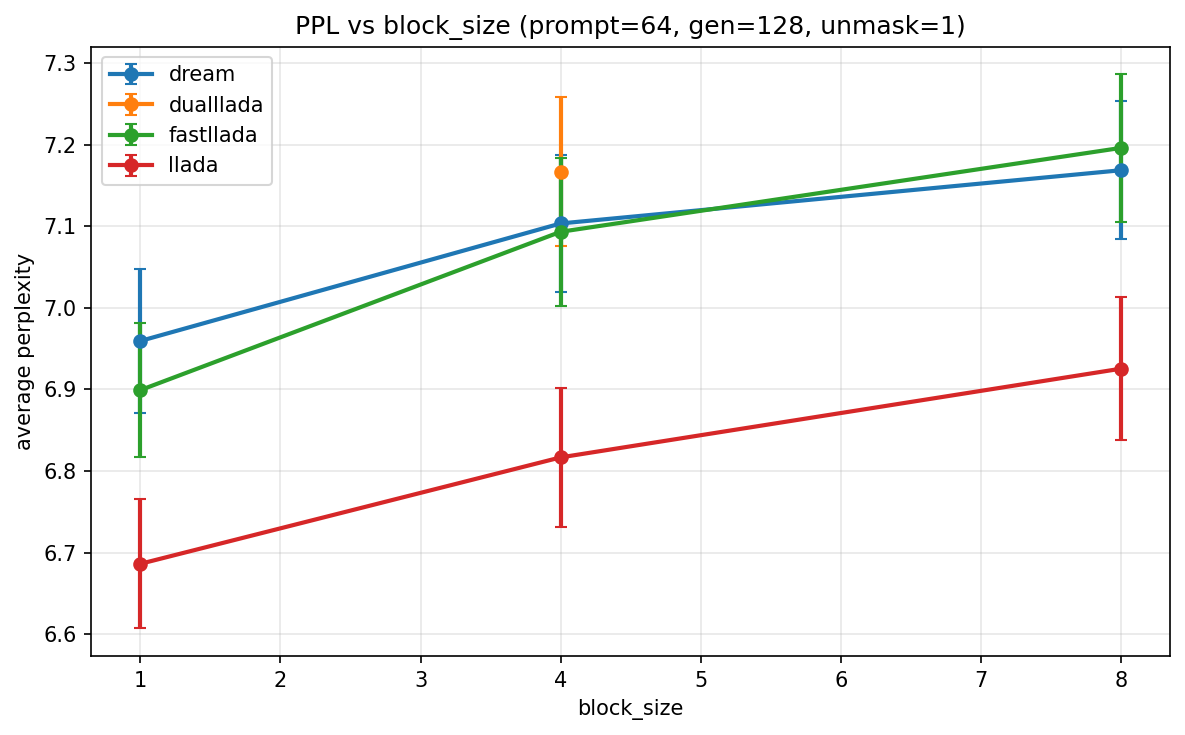

In [3]:

# ----------------------------
# 4) USAGE
# ----------------------------
if __name__ == "__main__":
    folder = "logs_ppl_all_compare"

    # Fix these:
    prompt_length = 64
    generation_length = 128
    unmask_number = 1

    data = load_results(
        folder=folder,
        prompt_length=prompt_length,
        generation_length=generation_length,
        unmask_number=unmask_number,
    )

    plot_ppl_vs_blocksize(
        data,
        title=f"PPL vs block_size (prompt={prompt_length}, gen={generation_length}, unmask={unmask_number})",
        savepath=f"ppl_vs_blocksize_p{prompt_length}_g{generation_length}_u{unmask_number}.png",
        show_errorbar=True,   # set False if you want plain lines only
    )
